# Feature Visualization by Optimization

Classifier neural network is differentiable with respect to the inputs, therefore the gradient descent can be used to maximize logits for a given class. In this way an image can be created such that the classifier strongly assigns it to the class. However, just optimizing the image creates high-frequency noise. To reduce this noise a bilateral filter can be used.

https://distill.pub/2017/feature-visualization/

## Configuration

Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms.v2 as transforms
import torchvision.transforms.v2.functional as TF

Smaller model leads to nicer images. We use previously created classifier with 80,177 parameters trained on CIFAR10.

In [2]:
from tiny_net import create_model

Configuration

In [3]:
DATA_DIR = './data'
MODELS_DIR = './models'

IMAGE_SIZE = 32
NUM_CLASSES = 10
LEARNING_RATE = 0.25
EPOCHS = 20000

In [4]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


## Data

In [5]:
test_transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float, scale=True),
])

In [6]:
test_dset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=test_transform)

Files already downloaded and verified


In [7]:
for num, name in enumerate(test_dset.classes):
    print(f'{num}: {name}')

0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


In [8]:
def dataset_show_image(dset, idx):
    X, Y = dset[idx]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.imshow(np.moveaxis(X.numpy(), 0, -1))
    ax.set_title(dset.classes[Y])
    plt.show()

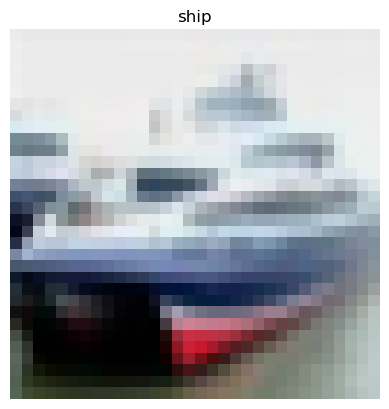

In [9]:
dataset_show_image(test_dset, 1)

## Model

In [10]:
model = create_model(DEVICE)

In [11]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 80,177


In [12]:
model.load_state_dict(torch.load(os.path.join(MODELS_DIR, 'residual_tiny.pt')))

<All keys matched successfully>

In [13]:
model.eval();

Freeze model:

In [14]:
for p in model.parameters():
    p.requires_grad = False

## Feature visualization

Bilateral filter, https://en.wikipedia.org/wiki/Bilateral_filter

In [15]:
class BilateralFilter(nn.Module):
    def __init__(self, kernel_size, sigma_color, sigma_space):
        super().__init__()
        self.kernel_size = kernel_size
        self.padding = (kernel_size - 1) // 2
        self.sigma_color = sigma_color
        self.register_buffer("spatial_kernel", self.gaussian_kernel(kernel_size, sigma_space))

    def forward(self, image):
        b, c, h, w = image.shape
        image_unf = F.unfold(image, self.kernel_size, padding=self.padding).view(b, c, self.kernel_size**2, h * w)
        image_ex = image.view(b, c, 1, h * w)
        weight = torch.exp(-(image_unf - image_ex)**2 / (2 * self.sigma_color**2))  * self.spatial_kernel
        norm = torch.sum(weight, dim=2)
        image_filtered = torch.sum(image_unf * weight, dim=2) / norm
        image_filtered = image_filtered.view(b, c, h, w)
        return image_filtered

    def gaussian_kernel(self, kernel_size, sigma):
        side = (kernel_size - 1) // 2
        ax = torch.arange(-side, side + 1)
        xx, yy = torch.meshgrid(ax, ax, indexing='ij')
        kernel = torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))
        kernel = kernel.view(-1, 1)
        return kernel

In [16]:
class VisualizationModel(nn.Module):
    def __init__(self, model, image):
        super().__init__()
        self.model = model
        self.p = nn.Parameter(self.image_to_param(image))
        self.filter = BilateralFilter(3, 1., 1.)

    def forward(self):
        image = self.get_image()
        logits = self.model(image.unsqueeze(0)).squeeze(0)
        return logits

    def image_to_param(self, image):
        p = torch.log(image / (1. - image))
        return p

    def set_image(self, image):
        with torch.no_grad():
            self.p.copy_(self.image_to_param(image))

    def get_image(self):
        image = torch.sigmoid(self.p)
        image = self.filter(image.unsqueeze(0)).squeeze(0)
        return image

    def get_pil_image(self):
        with torch.no_grad():
            image = self.get_image()
        image = image.cpu()
        image_pil = TF.to_pil_image(image)
        return image_pil

In [17]:
def train(num_steps, class_num, vis_model, optimizer):
    pbar = tqdm(range(num_steps), leave=True, ncols=140)
    for step in pbar:
        logits = vis_model()
        loss = -logits[class_num]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_postfix({'loss': loss.item()})

In [18]:
def plot_image_list(image_list, name_list, ncols=5):
    nrows, rem = divmod(len(image_list), ncols)
    if rem > 0: nrows +=1
          
    fig = plt.figure(figsize=(15, 6))
    for i, (image, name) in enumerate(zip(image_list, name_list)):
        ax = fig.add_subplot(nrows, ncols, i + 1)
        ax.set_axis_off()
        ax.imshow(image)
        ax.set_title(name)
    fig.show()

### Training

In [20]:
initial_image = torch.full((3, IMAGE_SIZE, IMAGE_SIZE), 0.01)
vis_model = VisualizationModel(model, initial_image).to(DEVICE)
params = [p for p in vis_model.parameters() if p.requires_grad]

image_list = []
for num, name in enumerate(test_dset.classes):
    print("Training:", name)
    vis_model.set_image(initial_image)
    optimizer = optim.Adam(params, lr=LEARNING_RATE)
    train(EPOCHS, num, vis_model, optimizer)
    image = vis_model.get_pil_image()
    image_list.append(image)

Training: airplane


100%|█████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:49<00:00, 182.10it/s, loss=-149]


Training: automobile


100%|████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:50<00:00, 180.84it/s, loss=-83.9]


Training: bird


100%|█████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:51<00:00, 178.66it/s, loss=-179]


Training: cat


100%|█████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:51<00:00, 178.85it/s, loss=-130]


Training: deer


100%|█████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:57<00:00, 170.08it/s, loss=-210]


Training: dog


100%|█████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:52<00:00, 177.10it/s, loss=-182]


Training: frog


100%|█████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:48<00:00, 183.83it/s, loss=-130]


Training: horse


100%|█████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:53<00:00, 176.24it/s, loss=-164]


Training: ship


100%|████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:51<00:00, 178.58it/s, loss=-99.4]


Training: truck


100%|████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:52<00:00, 178.19it/s, loss=-69.3]


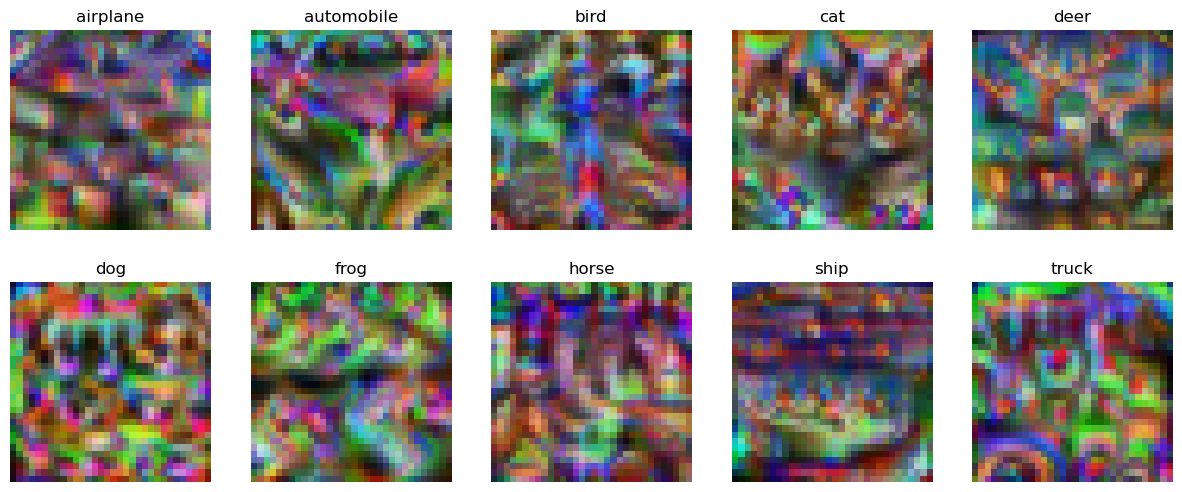

In [21]:
plot_image_list(image_list, test_dset.classes)